In [1]:
import mdtraj as md
import pyemma.coordinates as coor
import numpy as np
import matplotlib.pyplot as plt

In [2]:
gro = md.load('frame0_nw.gro')

In [3]:
traj = md.load('7oft_100mm_whole_wrap.trr', top=gro.top)

In [4]:
lig = gro.top.select('resname == hba')
# 88 * 15
lig_idx = np.arange(0,1320,15)

In [5]:
traj.superpose(gro, atom_indices=gro.top.select('backbone'))

<mdtraj.Trajectory with 30002 frames, 6532 atoms, 666 residues, and unitcells at 0x7fc3eeb0cfd0>

In [6]:
com_list = [0] * 88

for i in range(len(lig_idx)):
    small_traj = traj.atom_slice(lig[lig_idx[i]:lig_idx[i]+15])
    com_list[i] = md.compute_center_of_mass(small_traj)

In [50]:
com_list[-1]

array([[1.94285077, 5.78924363, 1.9624152 ],
       [1.94285093, 5.78925478, 1.96241474],
       [2.41888364, 5.75967594, 1.7543121 ],
       ...,
       [0.16253745, 5.06851482, 8.2709983 ],
       [0.25666363, 5.27047423, 7.89585916],
       [0.17183899, 5.4358287 , 7.86934597]])

In [8]:
import sklearn
from sklearn.cluster import DBSCAN

In [51]:
com_cat = np.concatenate(com_list)

In [52]:
cl = DBSCAN(eps=0.15, min_samples=6500).fit(com_cat)

In [53]:
len(set(cl.labels_))

2

In [34]:
def write_com_to_gro(com, file_name):
    ''' write center of mass point to gro file to open in VMD, chimera, or similiar'''
    with open(file_name, 'w') as f:
        f.write('Protein in water\n')
        f.write(' 1\n')
        f.write(f'    1GLU      N    1   {np.round(com[0], 3)}   {np.round(com[1], 3)}   {np.round(com[2], 3)}\n')
        f.write('  11.27360  11.27360  11.27360\n')

In [54]:
cluster_list = []
avg_list = []

for i in set(cl.labels_):
    if i == -1:
        continue
    cluster_list.append(com_cat[cl.labels_ == i])
    print(i, cluster_list[i].shape[0])
    avg_list.append(cluster_list[i].mean(axis=0))

0 15492


In [37]:
for i in range(2):
    write_com_to_gro(avg_list[i], f'cluster/7oft_100mm_cluster{i}.gro')

In [38]:
crystal = md.load('../../true_7oft.pdb')

In [39]:
cry_idx = crystal.top.select('resname == hba')
lig_rmsds = [0] * 88

In [40]:
def manual_rmsd(a,b):
    result = np.ndarray((a.shape[0],1), dtype='float32')
    N = b.shape[1]
    for i in range(a.shape[0]):
        result[i] = np.sqrt(np.sum((a[i] - b[0]) ** 2) / N)
    return result

def ex_rmsd(traj, ref, ref_frame=0, atom_indices_traj=None, atom_indices_ref=None, alignment_indices=None):
    'align to protein then take rmsd of ligand'
    traj.superpose(ref, frame=ref_frame, atom_indices=alignment_indices, parallel=True)
    small_traj = traj.atom_slice(atom_indices_traj)
    small_ref = ref.atom_slice(atom_indices_ref)
    f = manual_rmsd(small_traj.xyz, small_ref.xyz)
    return f

In [55]:
for i in range(len(lig_idx)):
    lig_rmsds[i] = ex_rmsd(traj, crystal, atom_indices_traj=lig[lig_idx[i]:lig_idx[i]+15], atom_indices_ref=cry_idx, alignment_indices=gro.top.select('backbone'))

In [56]:
time = np.arange(0, 300.02, 0.01)

In [66]:
lig_rmsds2 = lig_rmsds[:-1]
under_5_list = [0] * 88
for i in range(len(lig_rmsds2)):
    under_5_list[i] = (lig_rmsds2[i] < 0.5).sum()

In [68]:
for i in range(len(under_5_list)):
    print(i, under_5_list[i])

0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 4
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
40 0
41 0
42 0
43 0
44 0
45 0
46 0
47 0
48 0
49 0
50 0
51 0
52 0
53 0
54 0
55 0
56 0
57 0
58 0
59 0
60 0
61 0
62 0
63 0
64 3
65 0
66 0
67 224
68 0
69 0
70 0
71 0
72 0
73 0
74 0
75 0
76 0
77 0
78 0
79 0
80 446
81 0
82 0
83 0
84 0
85 38
86 0
87 0


Text(0, 0.5, 'Ligand RMSD (nm)')

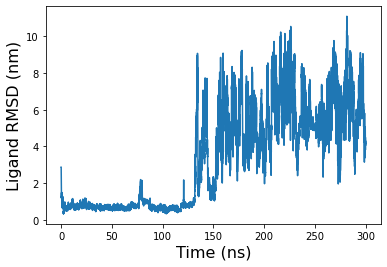

In [69]:
plt.plot(time, lig_rmsds[80])
plt.xlabel('Time (ns)', fontsize=16)
plt.ylabel('Ligand RMSD (nm)', fontsize=16)

Text(0, 0.5, 'Ligand RMSD (nm)')

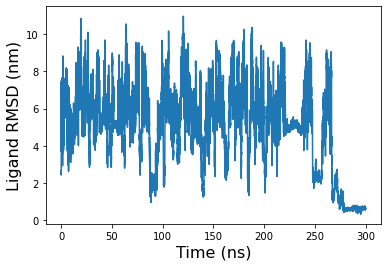

In [70]:
plt.plot(time, lig_rmsds[67])
plt.xlabel('Time (ns)', fontsize=16)
plt.ylabel('Ligand RMSD (nm)', fontsize=16)

In [71]:
np.save('lowest_lig_rmsd.npy', lig_rmsds[80])

In [72]:
lig_rmsds[80].min()

0.3301245

In [7]:
# contact analysis

In [9]:
sites = 1
site_list = [md.load(f'cluster/7oft_100mm_cluster{i}.gro') for i in range(sites)]

In [10]:
def calc_eu_dist(a,b):
    '''calculate the euclidean distance between two cartesian coordinate points'''
    dist = np.sqrt(np.sum((a - b) ** 2))
    return dist

In [11]:
def slice_spots(traj, sites, com_list, site_list, gro, lig, lig_idx, lig_atoms=20):
    '''takes trajectoy and retures seperate trajectories where ligands are in spots'''
    out_list3 = [0] * sites

    for i in range(sites):
        counter = 0
        for j in range(len(com_list)):
            #for k in range(traj.n_frames):
            d = [calc_eu_dist(l, site_list[i].xyz[0][0]) for l in com_list[j]]
            b = np.array(d)
            idx = np.where(b < 0.15)[0]
            if counter == 0:
                temp = traj[idx]
                temp2 = temp.atom_slice(np.concatenate((gro.top.select('protein'), lig[lig_idx[j]:lig_idx[j]+lig_atoms])))
                out_list3[i] = temp2
                counter = 1
            else:
                temp = traj[idx]                      
                temp2 = temp.atom_slice(np.concatenate((gro.top.select('protein'), lig[lig_idx[j]:lig_idx[j]+lig_atoms])))
                out_list3[i] = out_list3[i].join(temp2)
                
    return out_list3

In [12]:
out_list = slice_spots(traj, sites, com_list, site_list, gro, lig, lig_idx, lig_atoms=15)

In [13]:
out_list[0].save('sitetraj_cl0_F_s11.xtc')

In [14]:
start = out_list[0][0]

In [15]:
start.save('s11_frame0.gro')

In [16]:
new_lig = start.top.select('resname == hba and not name H')

In [17]:
res = np.zeros((315,2))
for i in range(315):
    res[i,0] = i
for i in range(315):
    res[i,1] = 315

In [18]:
def average_contacts(gro, traj_name, threshold):
    feat = coor.featurizer(gro)
    feat.add_residue_mindist(residue_pairs=res, threshold=threshold)
    min_dis = coor.load(traj_name, features=feat)
    mean = np.mean(min_dis.sum(axis=1))
    return mean

In [19]:
average_contacts(start, 'sitetraj_cl0_F_s11.xtc', 0.35)

4.334815

In [20]:
average_contacts(start, 'sitetraj_cl0_F_s11.xtc', 0.4)

8.443729